In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Scenario Setup

**Problem**: Training on Web images, deploying on Mobile images
- Web images: high quality, well-lit
- Mobile images: blurry, noisy, different lighting

In [4]:
# Generate base dataset (Web images)
# 2000 muestras: Datos abundantes y limpios
# 50 features: Características de las imágenes
# n_informative=30: 30 features realmente útiles para predecir
# n_redundant=10: 10 features redundantes (correlacionados)
# random_state=42: Para reproducibilidad
X_web, y_web = make_classification(n_samples=2000, n_features=50, n_informative=30,
                                    n_redundant=10, random_state=42)

# Generate Mobile images (different distribution: add noise + shift)
X_mobile, y_mobile = make_classification(n_samples=500, n_features=50, n_informative=30,
                                          n_redundant=10, random_state=99)
X_mobile = X_mobile + np.random.normal(0, 0.5, X_mobile.shape)  # Add noise (blur effect)
X_mobile = X_mobile * 0.8  # Shift distribution (lighting difference)

print(f"Web data: {X_web.shape[0]} samples")
print(f"Mobile data: {X_mobile.shape[0]} samples")

Web data: 2000 samples
Mobile data: 500 samples


## Dataset Split with Train-Dev

- **Training Set**: Web images (for training)
- **Train-Dev Set**: Web images (held out, not trained on)
- **Dev Set**: Mobile images (validation)
- **Test Set**: Mobile images (final evaluation)

In [5]:
# Split Web data: 70% training, 30% train-dev
# Train-Dev: Son datos Web que el modelo nunca ve durante
# entrenamiento. Sirven como "grupo de control" de la misma distribución.
X_train, X_train_dev, y_train, y_train_dev = train_test_split(
    X_web, y_web, test_size=0.3, random_state=42)

# Split Mobile data: 50% dev, 50% test
# 50% → Dev (250 muestras): Para evaluar en producción
# 50% → Test (250 muestras): Para evaluación final
X_dev, X_test, y_dev, y_test = train_test_split(
    X_mobile, y_mobile, test_size=0.5, random_state=42)

print("\nData splits:")
print(f"Training (Web): {X_train.shape[0]}")
print(f"Train-Dev (Web): {X_train_dev.shape[0]}")
print(f"Dev (Mobile): {X_dev.shape[0]}")
print(f"Test (Mobile): {X_test.shape[0]}")


Data splits:
Training (Web): 1400
Train-Dev (Web): 600
Dev (Mobile): 250
Test (Mobile): 250


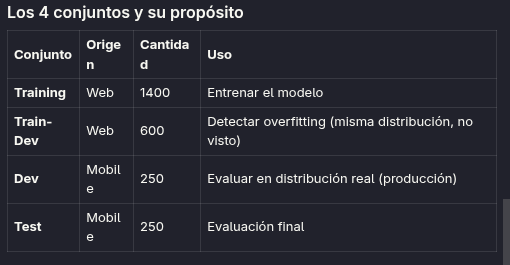

## Case 1: Overfitting (High Variance)

Model memorizes training data, fails on any new data (same distribution)

In [6]:
# Overfit model: very deep trees, no regularization
model_overfit = RandomForestClassifier(n_estimators=100, max_depth=50, 
                                       min_samples_split=2, random_state=42)
model_overfit.fit(X_train, y_train)

train_acc = accuracy_score(y_train, model_overfit.predict(X_train))
train_dev_acc = accuracy_score(y_train_dev, model_overfit.predict(X_train_dev))
dev_acc = accuracy_score(y_dev, model_overfit.predict(X_dev))

print("\nCase 1: Overfitting ")
print(f"Training error: {1 - train_acc:.3f}")
print(f"Train-Dev error: {1 - train_dev_acc:.3f}  ← High gap = Overfitting")
print(f"Dev error: {1 - dev_acc:.3f}")
print("\nDiagnosis: Model can't generalize even within Web distribution")


Case 1: Overfitting 
Training error: 0.000
Train-Dev error: 0.140  ← High gap = Overfitting
Dev error: 0.488

Diagnosis: Model can't generalize even within Web distribution


## Case 2: Data Mismatch

Model generalizes well on Web, but fails on Mobile distribution

In [33]:
# Well-regularized model
model_good = RandomForestClassifier(n_estimators=20, max_depth=5, 
                                    min_samples_split=50, random_state=42)
model_good.fit(X_train, y_train)

train_acc = accuracy_score(y_train, model_good.predict(X_train))
train_dev_acc = accuracy_score(y_train_dev, model_good.predict(X_train_dev))
dev_acc = accuracy_score(y_dev, model_good.predict(X_dev))

print("\nCase 2: Data Mismatch ")
print(f"Training error: {1 - train_acc:.3f}")
print(f"Train-Dev error: {1 - train_dev_acc:.3f}  ← Small gap = Good generalization")
print(f"Dev error: {1 - dev_acc:.3f}  ← Large gap = Data Mismatch")
print("\nDiagnosis: Model works on Web but not on Mobile distribution")


Case 2: Data Mismatch 
Training error: 0.129
Train-Dev error: 0.235  ← Small gap = Good generalization
Dev error: 0.524  ← Large gap = Data Mismatch

Diagnosis: Model works on Web but not on Mobile distribution


(no hay una demostracion pura del data mismatch ya que el dataset es sintetico y no hay una diferencia tan marcada entre ambos conjuntos de datos)

## Gap Analysis Visualization

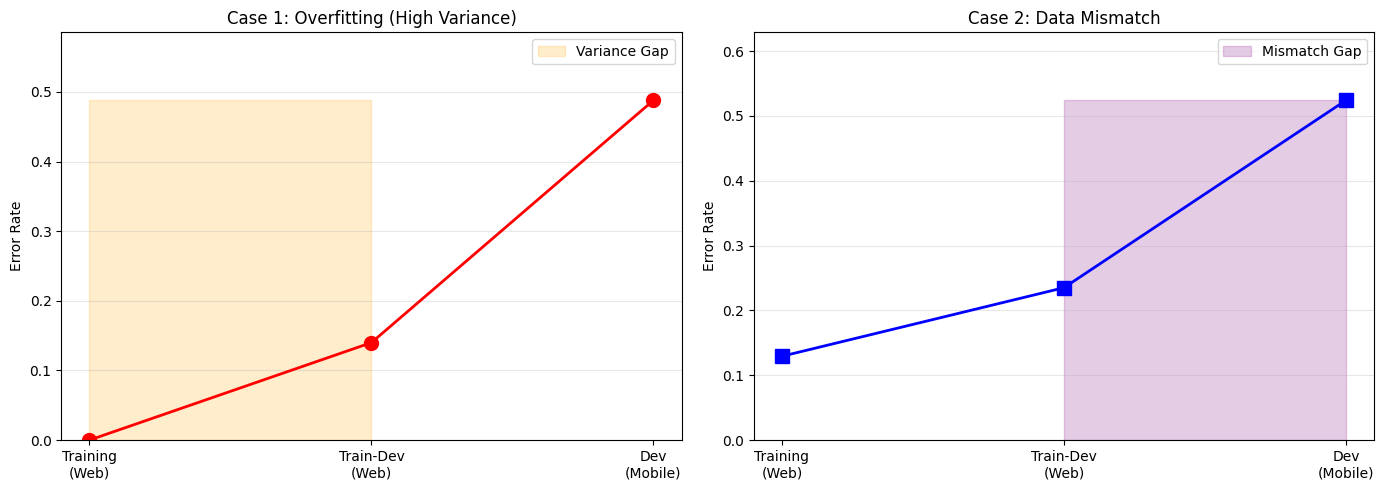

In [34]:
# Compute errors for both models
errors_overfit = [
    1 - accuracy_score(y_train, model_overfit.predict(X_train)),
    1 - accuracy_score(y_train_dev, model_overfit.predict(X_train_dev)),
    1 - accuracy_score(y_dev, model_overfit.predict(X_dev))
]

errors_mismatch = [
    1 - accuracy_score(y_train, model_good.predict(X_train)),
    1 - accuracy_score(y_train_dev, model_good.predict(X_train_dev)),
    1 - accuracy_score(y_dev, model_good.predict(X_dev))
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
x_labels = ['Training\n(Web)', 'Train-Dev\n(Web)', 'Dev\n(Mobile)']
x_pos = range(len(x_labels))

# Case 1: Overfitting
ax1.plot(x_pos, errors_overfit, marker='o', linewidth=2, markersize=10, color='red')
ax1.fill_between([0, 1], 0, max(errors_overfit), alpha=0.2, color='orange', 
                  label='Variance Gap')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels)
ax1.set_ylabel('Error Rate')
ax1.set_title('Case 1: Overfitting (High Variance)')
ax1.set_ylim(0, max(errors_overfit) * 1.2)
ax1.grid(alpha=0.3, axis='y')
ax1.legend()

# Case 2: Data Mismatch
ax2.plot(x_pos, errors_mismatch, marker='s', linewidth=2, markersize=10, color='blue')
ax2.fill_between([1, 2], 0, max(errors_mismatch), alpha=0.2, color='purple', 
                  label='Mismatch Gap')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x_labels)
ax2.set_ylabel('Error Rate')
ax2.set_title('Case 2: Data Mismatch')
ax2.set_ylim(0, max(errors_mismatch) * 1.2)
ax2.grid(alpha=0.3, axis='y')
ax2.legend()

plt.tight_layout()
plt.show()

## Solutions

**For Overfitting:**
- Regularization (reduce model complexity)
- More training data
- Feature selection

**For Data Mismatch:**
- Collect more Mobile data
- Artificial data synthesis (add noise/blur to Web images)
- Domain adaptation techniques

## Key Takeaway

The **Train-Dev set** is the diagnostic tool:
- Large gap between Training and Train-Dev → **Overfitting**
- Large gap between Train-Dev and Dev → **Data Mismatch**